In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1337.47it/s]


In [2]:
device = "mps"
block_size = 100
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=192, num_layers=3):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTFull(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size)).to(bool).to(device))

    def forward(self, x):
        B, T, _ = x.shape
        x = x + self.attn(self.ln1(x), self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# https://arxiv.org/pdf/2105.14103.pdf
# I am not 100% sure this is correct but it seems to work :shrug:
# unlike with regular attention, we don't need (T, T, C) shape for W, we only need (T, T)
# and those are learned, so we exchange the memory overhead for T^2 extra params per layer
class AFTFull(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.wbias = nn.Parameter(torch.ones(block_size, block_size), requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)

        exp_w = self.wbias[:T,:T].masked_fill(mask[:T, :T], -float("Inf")).unsqueeze(0).exp()
        exp_k = k.clamp(max=20).exp()

        weighted_avg = exp_w @ (exp_k * v) / (exp_w @ exp_k)
        Yt = F.sigmoid(q) * weighted_avg
        return self.proj(Yt)


class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 1.4 M 
-------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.560     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]And nowvjkdQzgHReEgUD;&
V;M RsBpR.ufb!x-pveTvLfHjTvI?uU?uxEwrRo?yvl?:WU
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 209/209 [00:07<00:00, 27.69it/s, loss=2.23, v_num=64]And now.

BRICIER:
Cich mry hyou nou heree hendst yow?


MEO:
Hould you
Epoch 1: 100%|██████████| 209/209 [00:06<00:00, 30.39it/s, loss=1.9, v_num=64, test_loss=2.240] And now you go to wrain
I pancent won scond theance of mown statirs.

B
Epoch 2: 100%|██████████| 209/209 [00:06<00:00, 30.51it/s, loss=1.72, v_num=64, test_loss=1.980]And now, for thous.

First Cits:
For mand; as him me me or win thy so, 
Epoch 3: 100%|██████████| 209/209 [00:06<00:00, 30.47it/s, loss=1.63, v_num=64, test_loss=1.870]And now, their speak in sprise
Of you have to moverein to death and min
Epoch 4: 100%|██████████| 209/209 [00:06<00:00, 30.30it/s, loss=1.55, v_num=64, test_loss=1.770]And now to be the food,
Or the wretchey done that-love that abselish.


Epoch 5: 100%|██████████| 209/209 [00:06<00:00, 30.27it/s, loss=1.49, v_num=64, test_loss=1.700]And now being;
Worthy bard with alls he haples mery and land;
That all 
Epoch 6: 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 209/209 [00:12<00:00, 16.51it/s, loss=1.17, v_num=64, test_loss=1.390]


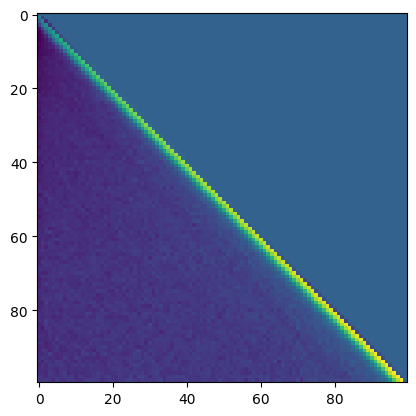

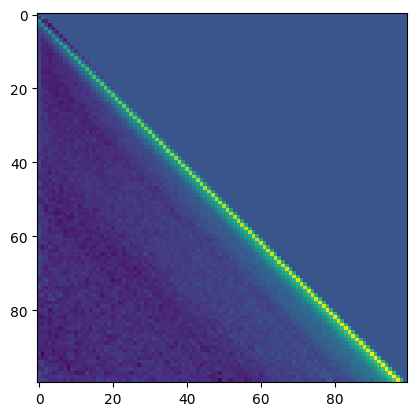

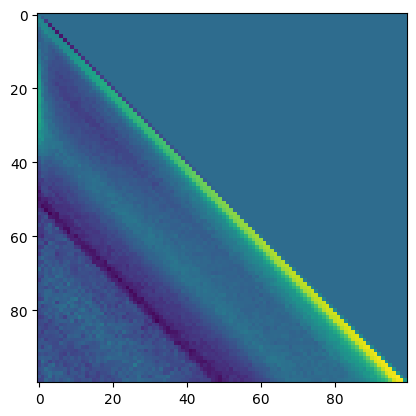

In [4]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.attn.wbias.detach().numpy())

In [5]:
print(model.generate("O God, O God!", 1024))

O God, O God! how if
he was none through his commend missive me
As misforment hight within the lechets? why, this should he
henped the work, as we rest.

BLUNT:
As she had likeness, and art thou that so strucket-word for me:
His battleman till was not well, and have borne
Our coronationereign so lights again, he
was a well-house to become the worn of malice of their feats buds
Of blown, with annot parture marriong
Herein stand full womining to the death
Shall benderated his countryments, and a beggardy as
any children is hast reeled me apprehended.

BUCKINGHAM:
Not behold us in this son as a woman
That shall be so suguised on to strew him with thee
To the worsey: it is not time to brought him to
a minite on the difference another to-morrow
His churl'd but forth the warm of clothes on the helm:
Bid him some same, my lords, that I have.

CAPULET:
With whole hearted invomenteous sweets as two.

DUCHESS OF YORK:
I do believe my lord?

PRINCE EDWARD:
No noble even soul heaven, to comfort me